In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import numpy as np
import matplotlib.pyplot as plt
import os.path as path
import wget
import os
from scipy.stats import chi2
from scipy.stats import t
from tqdm import tqdm
import sympy as sym

In [2]:
sample = np.array([0.974,0.950,0.932,1.104,1.038,0.920,0.935,0.907,0.810,0.915])

In [3]:
mean = np.mean(sample)
print(mean)

0.9484999999999999


In [4]:
def Resample(sample):
    
    resample_ = np.random.choice( sample, size = len(sample), replace = True )
    return resample_

In [5]:
np.mean(Resample(sample))

0.9126

In [6]:
def Bootstrapping(sample,N=10000):
    
    Mean_Dist = np.zeros(N)
    
    for i in tqdm(range(N)):
        resample = Resample(sample)
        Mean_Dist[i] = np.mean(resample)
        
    return Mean_Dist

In [8]:
Mean_Dist = Bootstrapping(sample)

100%|██████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 14044.53it/s]


In [9]:
mean = np.percentile(Mean_Dist,50)
print(mean)
q1 = np.quantile( a = Mean_Dist, q=[0.16,0.84] )
q2 = np.quantile( a = Mean_Dist, q=[0.023,0.977] )

q1

0.9480000000000001


array([0.9253, 0.9719])

In [10]:
Mean_Dist = Bootstrapping(sample)

100%|██████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 14202.28it/s]


In [11]:
errorinf = mean-q1[0]
errorsup = q1[1] - mean
print(errorinf,errorsup)

0.022700000000000053 0.02389999999999992


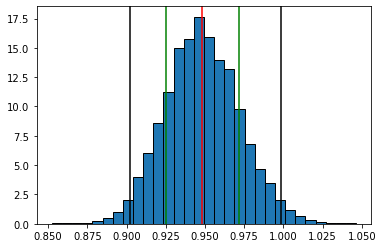

In [12]:
plt.hist(Mean_Dist, bins=30, density=True, ec='k')
plt.axvline(x=mean,color='r')
plt.axvline(x=q1[0],color='g')
plt.axvline(x=q1[1],color='g')
plt.axvline(x=q2[0],color='k')
plt.axvline(x=q2[1],color='k')

$$ \hat{\mu} = 0.948_{0.022}^{0.023}  at 68\% CL $$

In [13]:
# Descargamos data
if not path.exists('Data'):
    os.mkdir('Data')

!rm Data/*

file = 'Data/data.csv'
url = 'https://raw.githubusercontent.com/asegura4488/Database/main/MetodosComputacionalesReforma/MinimosCuadratico.txt'
#url = 'https://raw.githubusercontent.com/asegura4488/Database/main/MetodosComputacionalesReforma/MinimosLineal.txt'

if not path.exists(file):
    Path_ = wget.download(url,file)
    print('File loaded')
else:
    Path_ = file

100% [..................................................................................] 521 / 521File loaded


In [14]:
Data = np.loadtxt(Path_)

In [15]:
x = Data[:,0]
y = Data[:,1]
N = len(x)
sigma = np.random.uniform(1,4,size=N)
sigma

array([1.03484137, 3.17933406, 2.99103578, 3.69290956, 3.76193934,
       2.60753337, 1.03328802, 3.35378247, 2.23574976, 1.6938684 ,
       2.41700578, 1.61686089, 3.22400993, 2.00180352, 1.00782589,
       2.05649785, 2.78091363, 2.35052048, 1.23813607, 2.51871065])

In [16]:
def GetFit(x,y,n=3):
    
    size = len(x)
    b = y
    
    A = np.ones((size,n+1))
    
    for i in range(1,n+1):
        A[:,i] = x**(i)

    # Hacer ajuste cuadratico
    
    M = np.dot(A.T,A)
    bt = np.dot(A.T,b)
    
    xsol = np.linalg.solve(M,bt)

    return xsol

In [17]:
n = 2 # order of the polynomial
param = GetFit(x,y,n=n)
print(param)

[1.22132054 6.09075205 2.9565874 ]


In [18]:
def GetModel(x,p):
    
    y = 0.
    for i in range(len(p)):
        y += p[i]*x**i
    
    return y

In [19]:
X = sym.Symbol('x',real=True)
GetModel(X,param)

2.95658740177385*x**2 + 6.0907520463624*x + 1.2213205361703

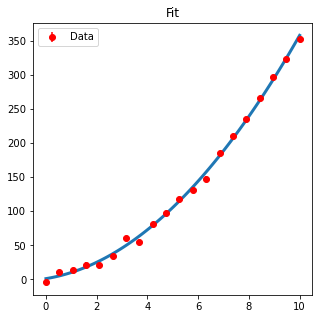

In [20]:
t = np.linspace(np.min(x),np.max(x),100)

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)
ax.errorbar(x,y,yerr=sigma,fmt='o',color='r',label='Data')
ax.set_title('Fit')
ax.plot(t,GetModel(t,param),lw=3) 
#ax.plot(t,GetModel(t,param), label="Parameters: {0}".format(np.round(param,2))) 
ax.legend(loc=0)

In [21]:
def GetChi2(x,y,sigma,p,reducido=True):
    
    df = (len(x) - len(p) - 1) 
    
    if not reducido:
        return np.sum( ( ( y - GetModel(x,p) )/sigma )**2 ) , df
    else:   
        return np.sum( ( ( y - GetModel(x,p) )/sigma )**2 ) / df ,df

In [22]:
param = GetFit(x,y,n)
Chi2,df = GetChi2(x,y,sigma,param)
print(Chi2)

12.39286077272197


# Bootstraping

In [23]:
dict1 = dict(zip(x,y))
#dict1

In [26]:
def GetBootstrapping(x,n=3,Ntrials=int(3e4)):
    
    Values = np.zeros( (Ntrials, n+1) )
    
    for i in tqdm(range(Ntrials)):
        
        x1 = Resample(x)
        
        y1 = np.array([])
        
        for j in x1:
            y1 = np.append(y1,dict1[j])
            
        p = GetFit(x1,y1,n)
        
        Values[i] = p
        
    return Values

In [27]:
Mean_Dist = GetBootstrapping(x,n=n)

100%|███████████████████████████████████████████████████████| 30000/30000 [00:10<00:00, 2954.93it/s]


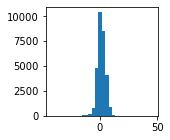

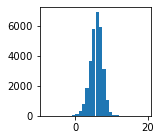

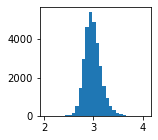

In [28]:
for i in range(n+1):
    fig = plt.figure(figsize=(2,2))
    plt.hist( Mean_Dist[:,i], bins=30 )

In [29]:
mean = np.percentile(Mean_Dist, 50, axis=0 )
mean

array([1.4095065 , 5.96208492, 2.96975889])

In [30]:
q1 = np.quantile( a = Mean_Dist, q=[0.16,0.84], axis=0 )
q1

array([[-1.57963942,  4.25962728,  2.82743186],
       [ 4.85912424,  7.44339135,  3.14002758]])

In [31]:
errorsup = q1[1] - mean
errorinf = mean - q1[0]
print(errorsup)
print(errorinf)

[3.44961774 1.48130643 0.17026869]
[2.98914592 1.70245763 0.14232703]


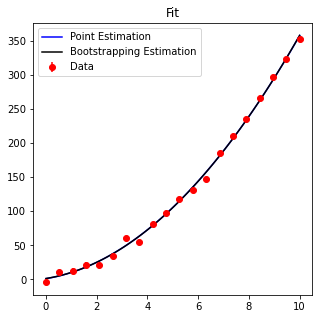

In [32]:
t = np.linspace(np.min(x),np.max(x),100)

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)
ax.errorbar(x,y,yerr=sigma,fmt='o',color='r',label='Data')
ax.set_title('Fit')


ax.plot(t,GetModel(t,param),color='b', label='Point Estimation') 
bootsparam=[i for i in mean]
ax.plot(t,GetModel(t,bootsparam),color='k', label='Bootstrapping Estimation') 
ax.legend(loc=0)

<ErrorbarContainer object of 3 artists>

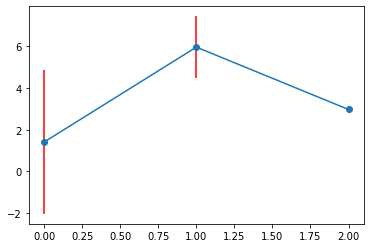

In [33]:
p1 = np.arange(0,len(mean),1)
plt.errorbar(p1,mean,yerr=errorsup,marker='o',ecolor='r')